In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

In [4]:
sns.set(style="whitegrid")  # Seaborn Grid Style

## read

In [213]:
df = pd.read_csv('Data/df_preprocessed.csv')
fert = pd.read_csv('Data/fert_preprocessed.csv')
pest = pd.read_csv('Data/pest_preprocessed.csv')

# df

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143236 entries, 0 to 143235
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  143236 non-null  object 
 1   Crop                  143236 non-null  object 
 2   Year                  143236 non-null  int64  
 3   area_harvested_ha     143236 non-null  float64
 4   production_tonnes     143236 non-null  float64
 5   yield_hg/ha           143236 non-null  float64
 6   avg_rainfall_mm_year  143236 non-null  float64
 7   avg_temp_ºC           143236 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 8.7+ MB


In [148]:
# convert year to object type, because it's discrete.
df['Year'] = df['Year'].astype(object)

In [149]:
df.head(2)

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,Wheat,1990,1570000.0,1650000.0,10510.0,327.0,14.38
1,Afghanistan,Wheat,1991,1690000.0,1726000.0,10213.0,327.0,14.38


In [150]:
df_corr = df.copy()

In [151]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143236 entries, 0 to 143235
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  143236 non-null  object 
 1   Crop                  143236 non-null  object 
 2   Year                  143236 non-null  object 
 3   area_harvested_ha     143236 non-null  float64
 4   production_tonnes     143236 non-null  float64
 5   yield_hg/ha           143236 non-null  float64
 6   avg_rainfall_mm_year  143236 non-null  float64
 7   avg_temp_ºC           143236 non-null  float64
dtypes: float64(5), object(3)
memory usage: 8.7+ MB


In [152]:
# encode the object type variables to analize the correlation

from sklearn.preprocessing import LabelEncoder

# create an instance of the encoder
encoder = LabelEncoder() 
# Fit and transform the LabelEncoder on the column
for columns in df_corr.columns:
    if df_corr[columns].dtype == 'object':
        df_corr[columns] = encoder.fit_transform(df_corr[columns])

<Axes: >

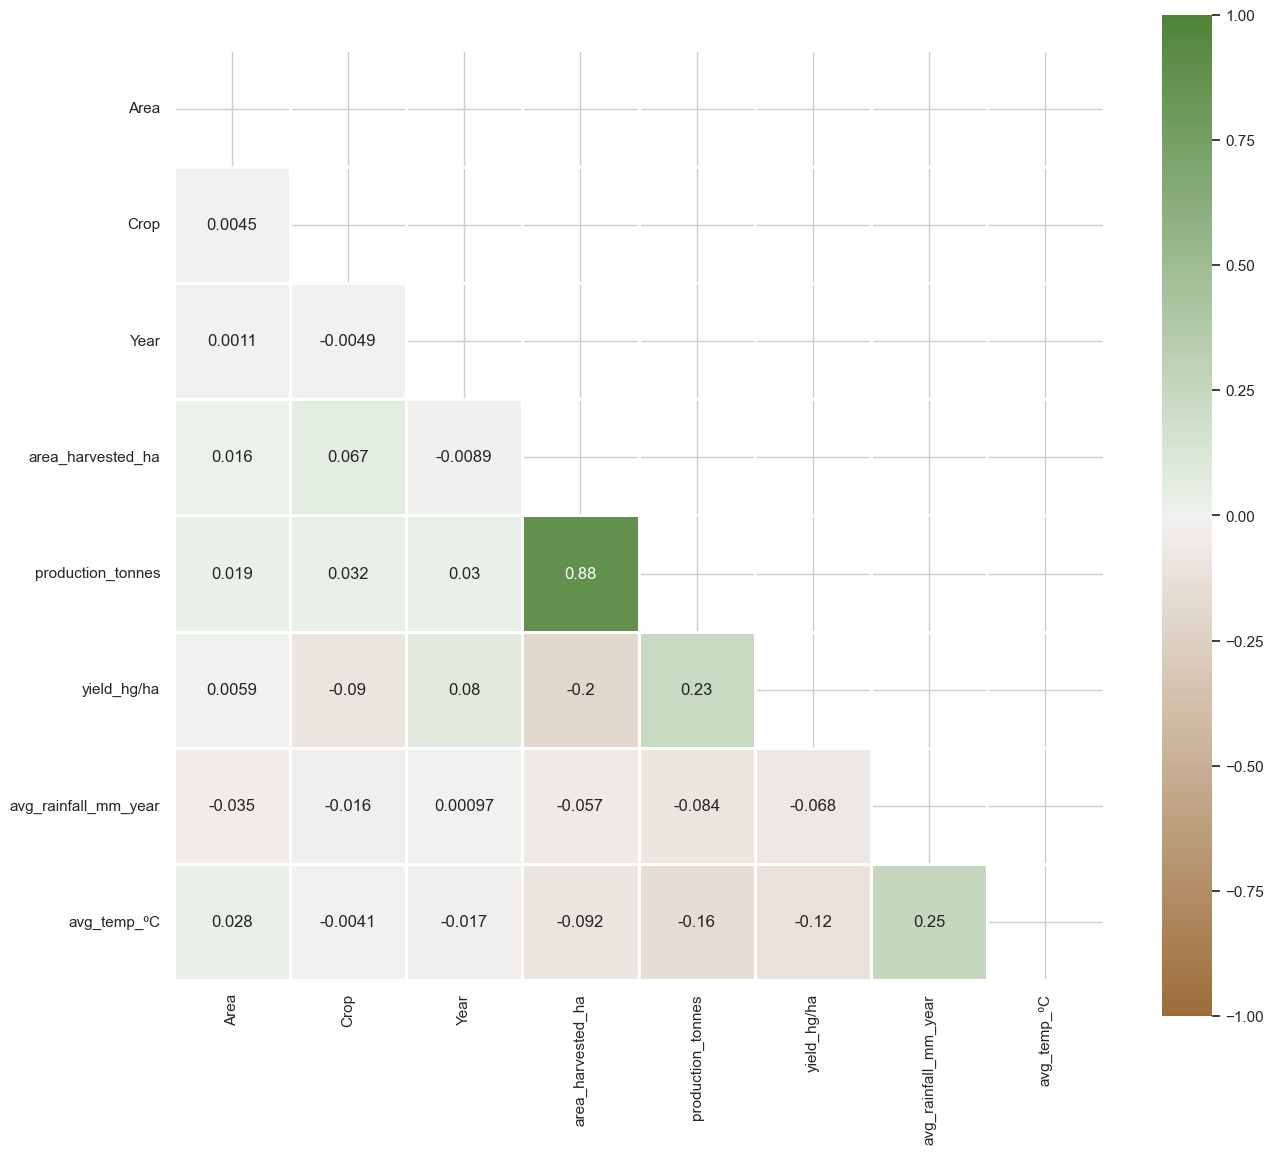

In [153]:
# Spearman's method 
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool)) 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(45, 120, s=75, l=50, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask[0:9,0:9], cmap=cmap, vmax=1, center=0, vmin=-1,  
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot = True)      

In [ ]:
# Hacemos la inversión de la codificación para una columna específica (por ejemplo, 'columna_1')
# inverted_values = encoder.inverse_transform(df_corr['columna_1'])

In [253]:
df.describe(include='object')

,Area,Crop
count,143236,143236
unique,162,50
top,China,"Other vegetables, fresh n.e.c."
freq,1648,4990


### YIELD

<Axes: xlabel='Year'>

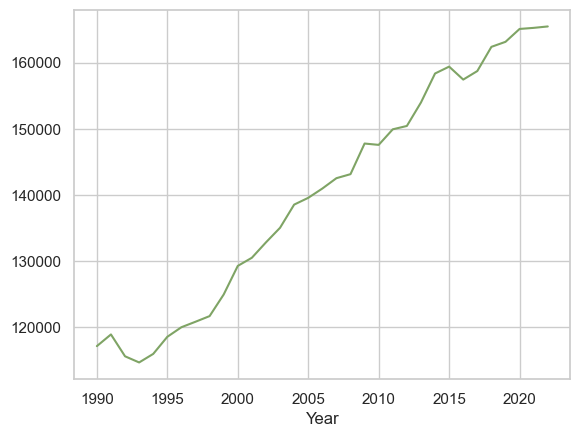

In [154]:
df.groupby('Year')['yield_hg/ha'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'yield_hg/ha' for each year.

In [155]:
max_yield = df['yield_hg/ha'].max()
df[df['yield_hg/ha']==max_yield]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
98828,Oman,Cucumbers and gherkins,2010,36.0,31519.0,8755278.0,125.0,28.02


In [156]:
min_yield = df['yield_hg/ha'].min()
df[df['yield_hg/ha']==min_yield]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
2098,Algeria,Other pulses n.e.c.,1997,79950.0,75.0,9.0,89.0,24.02


In [157]:
# Average yield for each crop over all years
crops_byyield = df.groupby('Crop')['yield_hg/ha'].mean().sort_values(ascending=False).reset_index()

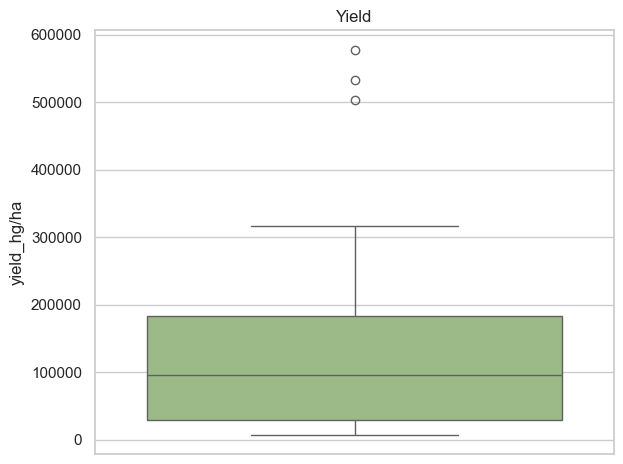

In [158]:
# Create boxplot to visualize outliers

fig = sns.boxplot(y=crops_byyield['yield_hg/ha'], data=crops_byyield, color = agro[1]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [159]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(crops_byyield, crops_byyield['yield_hg/ha'])

# Create boxplot to visualize the distribution without outliers

fig = sns.boxplot(y=crops_byyield['yield_hg/ha'], data=crops_byyield, color = agro[1]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

,Crop,yield_hg/ha
0,Sugar cane,413425.522625
1,Tomatoes,413425.522625
2,Cucumbers and gherkins,413425.522625
3,Eggplants (aubergines),316056.844006
4,Carrots and turnips,247914.106053
5,"Chillies and peppers, green (Capsicum spp. and...",247559.979907
6,Cabbages,240523.915921
7,Pineapples,218011.024899
8,Watermelons,217206.895118
9,"Onions and shallots, dry (excluding dehydrated)",204814.082166


In [174]:
fig = px.bar(crops_byyield, x='yield_hg/ha', y='Crop', color='yield_hg/ha', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by average yield (hg/ha)", title_x=0.5,xaxis_title='average yield (hg/ha)',yaxis_title = '',
                  coloraxis_colorbar_title='average yield (hg/ha)') 

fig.show()

### AREA HARVESTED

In [343]:
df.head()

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,Wheat,1990,1570000.0,1650000.0,10510.0,327.0,14.38
1,Afghanistan,Wheat,1991,1690000.0,1726000.0,10213.0,327.0,14.38
2,Afghanistan,Wheat,1992,1600000.0,1650000.0,10313.0,327.0,14.38
3,Afghanistan,Wheat,1993,1900000.0,1940000.0,10211.0,327.0,14.38
4,Afghanistan,Wheat,1994,2000000.0,2050000.0,10250.0,327.0,14.38


<Axes: xlabel='Year'>

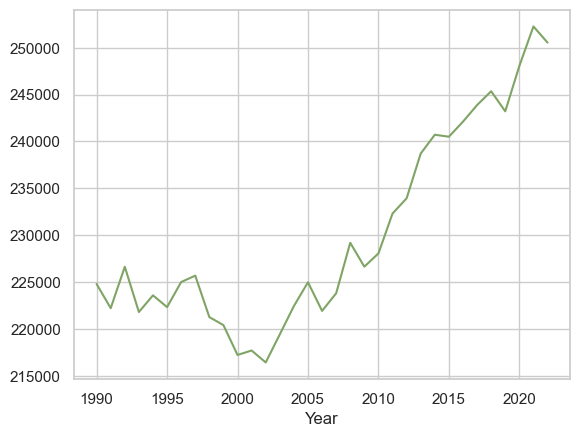

In [164]:
df.groupby('Year')['area_harvested_ha'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'area_harvested_ha' for each year.

In [165]:
max_area= df['area_harvested_ha'].max()
df[df['area_harvested_ha']==max_area]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
58794,India,Rice,2022,46400000.0,196245700.0,42294.0,1083.0,25.14


In [166]:
min_area = df['area_harvested_ha'].min()
df[df['area_harvested_ha']==min_area]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
2658,Algeria,Bananas,2006,1.0,11.00,110000.0,89.0,24.02
2659,Algeria,Bananas,2007,1.0,11.00,80882.0,89.0,24.02
3909,Antigua and Barbuda,Cabbages,2020,1.0,1.80,13846.0,1030.0,27.20
4111,Antigua and Barbuda,"Onions and shallots, dry (excluding dehydrated)",2021,1.0,5.05,83609.0,1030.0,27.20
4173,Antigua and Barbuda,Carrots and turnips,2017,1.0,11.42,127666.0,1030.0,27.20
...,...,...,...,...,...,...,...,...
125000,Switzerland,"Other fruits, n.e.c.",2018,1.0,24.38,366410.0,1537.0,7.24
125001,Switzerland,"Other fruits, n.e.c.",2019,1.0,25.65,256642.0,1537.0,7.24
125002,Switzerland,"Other fruits, n.e.c.",2020,1.0,25.14,251454.0,1537.0,7.24
125003,Switzerland,"Other fruits, n.e.c.",2021,1.0,25.05,258656.0,1537.0,7.24


In [72]:
# Average area harvested for each crop over all years
crops_byarea = df.groupby('Crop')['area_harvested_ha'].mean().sort_values(ascending=False).reset_index()

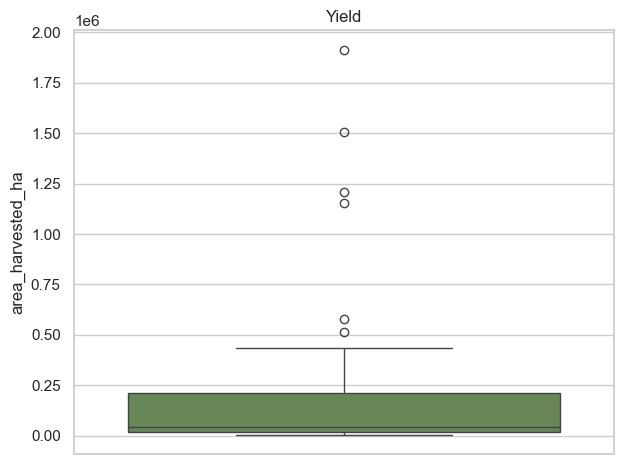

In [168]:
# Create boxplot to visualize outliers

fig = sns.boxplot(y=crops_byarea['area_harvested_ha'], data=crops_byarea, color = agro[3]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

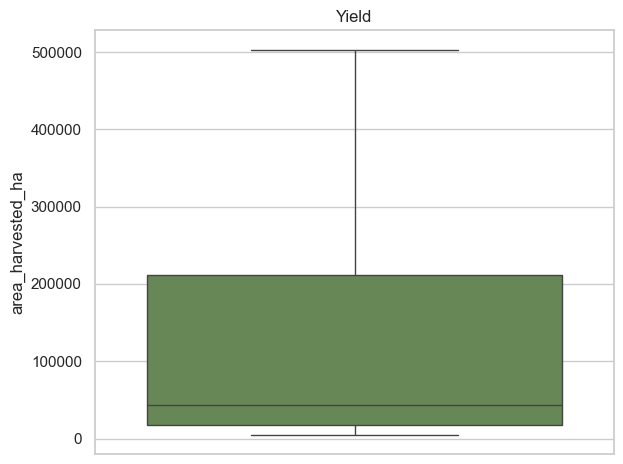

In [169]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(crops_byarea, crops_byarea['area_harvested_ha'])

# Create boxplot to visualize the distribution without outliers

fig = sns.boxplot(y=crops_byarea['area_harvested_ha'], data=crops_byarea, color = agro[3]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [175]:
fig = px.bar(crops_byarea, x='area_harvested_ha', y='Crop', color='area_harvested_ha', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by average area (ha)", title_x=0.5,xaxis_title='average area (ha)',yaxis_title = '',
                  coloraxis_colorbar_title='average area (ha)')  

### PRODUCTION

In [348]:
df.head()

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,Wheat,1990,1570000.0,1650000.0,10510.0,327.0,14.38
1,Afghanistan,Wheat,1991,1690000.0,1726000.0,10213.0,327.0,14.38
2,Afghanistan,Wheat,1992,1600000.0,1650000.0,10313.0,327.0,14.38
3,Afghanistan,Wheat,1993,1900000.0,1940000.0,10211.0,327.0,14.38
4,Afghanistan,Wheat,1994,2000000.0,2050000.0,10250.0,327.0,14.38


<Axes: xlabel='Year'>

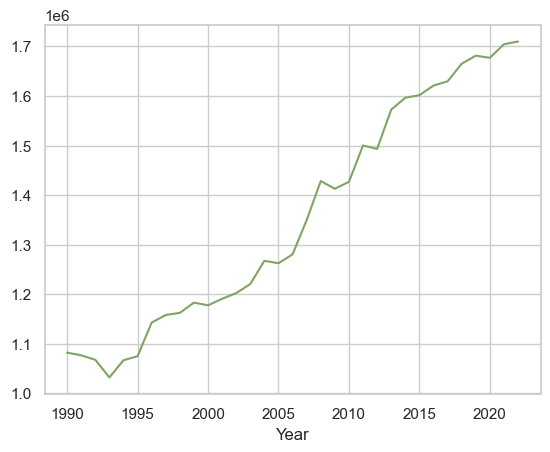

In [13]:
df.groupby('Year')['production_tonnes'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'production_tonnes' for each year.

In [349]:
max_production= df['production_tonnes'].max()
df[df['production_tonnes']==max_production]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
19448,Brazil,Sugar cane,2016,10223894.0,768594154.0,751763.0,1771.5,25.56


In [350]:
min_production = df['production_tonnes'].min()
df[df['production_tonnes']==min_production]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
94010,New Caledonia,Other pulses n.e.c.,2021,6.0,0.06,107.0,1183.25,23.23


In [66]:
# Average production for each crop over all years
crops_byproduction = df.groupby('Crop')['production_tonnes'].mean().sort_values(ascending=False).reset_index()

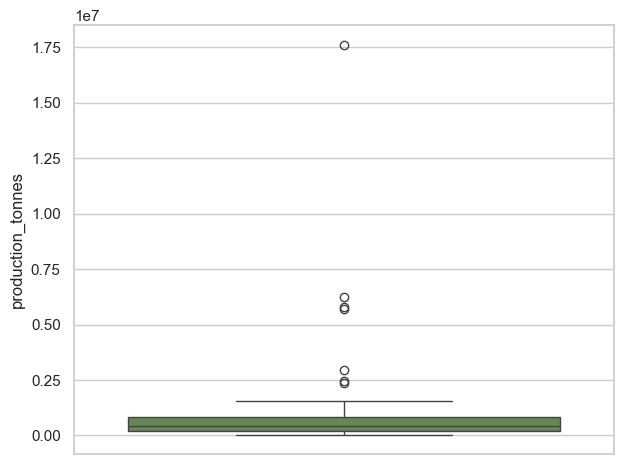

In [176]:
# Create boxplot to visualize the outliers

fig = sns.boxplot(y=crops_byproduction['production_tonnes'], data=crops_byproduction, color = agro[3]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

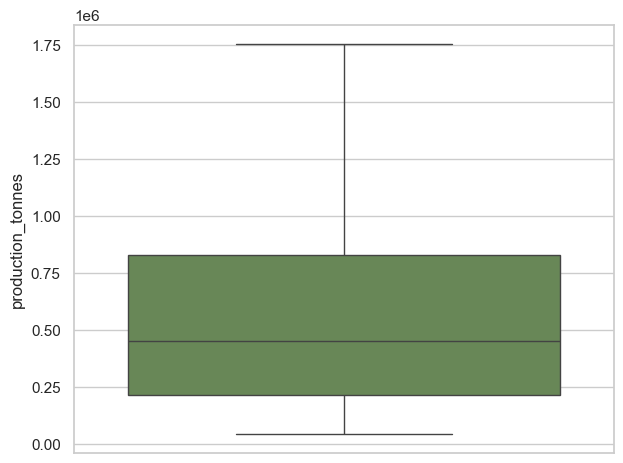

In [178]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(crops_byproduction, crops_byproduction['production_tonnes'])

# Create boxplot to visualize the distribution without outliers

fig = sns.boxplot(y=crops_byproduction['production_tonnes'], data=crops_byproduction, color = agro[3]) 

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [181]:
fig = px.bar(crops_byproduction, x='production_tonnes', y='Crop', color='production_tonnes', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by production (tonnes)", title_x=0.5,xaxis_title='average production (tonnes)',yaxis_title = '',
                  coloraxis_colorbar_title='average production (tonnes)')  

### Area (Countries)

#### INTERACTIVE MAPS

In [24]:
# Interactive maps
import folium
from folium import plugins
from folium.plugins import FastMarkerCluster
import geopandas as gpd

In [34]:
map_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"

In [35]:
geo = gpd.read_file(map_url)

In [36]:
geo = geo[['SOVEREIGNT','geometry']].copy()
# change the name to the column 'name'
geo.columns = ['Area','geometry']

In [355]:
geo.isnull().sum() 

Area        0
geometry    0
dtype: int64

In [356]:
geo.shape

(177, 2)

In [37]:
# correction of country names
geo['Area'].replace('United States of America','United States', inplace=True)
geo['Area'].replace('Republic of the Congo','Congo', inplace=True)

In [38]:
# Average area harvested by Country over all years
country_byarea = df.groupby('Area')['area_harvested_ha'].mean().sort_values(ascending=True).reset_index()
# Average yield by Country over all years
country_byyield = df.groupby('Area')['yield_hg/ha'].mean().sort_values(ascending=True).reset_index()
# Average rain by Country over all years
rain_byarea = df.groupby('Area')['avg_rainfall_mm_year'].mean().sort_values(ascending=True).reset_index()

In [43]:
rain_byarea

,Area,avg_rainfall_mm_year
0,Libya,56.00
1,Saudi Arabia,59.00
2,Qatar,74.00
3,United Arab Emirates,78.00
4,Bahrain,83.00
...,...,...
157,Panama,2928.00
158,Solomon Islands,3028.00
159,Papua New Guinea,3142.00
160,Sao Tome and Principe,3200.00


In [41]:
#Creamos un nuevo df llamado geo_final con la información de geo y la columna del conteo de alojamientos, utilizando como común la columna de barrio
geo1 = pd.merge(geo, country_byarea[['Area', 'area_harvested_ha']], on='Area', how='inner') 
#Creamos un nuevo df llamado geo2 con la información de geo1 y la columna del precio medio por barrio, utilizando como común la columna de barrio
geo2 = pd.merge(geo1, country_byyield[['Area', 'yield_hg/ha']], on='Area', how='inner') 
#Creamos un nuevo df llamado geo_final con la información de geo2 y la columna del precio medio por barrio, utilizando como común la columna de barrio
geo_final = pd.merge(geo2, rain_byarea[['Area', 'avg_rainfall_mm_year']], on='Area', how='inner')

In [45]:
geo_final.shape

(146, 5)

In [46]:
# Guardar el geo_final a un csv
geo_final.to_csv('geo_final.csv', index=False)

In [47]:
geo_final.head(2)

,Area,geometry,area_harvested_ha,yield_hg/ha,avg_rainfall_mm_year
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",4384.816667,89509.260714,2592.0
1,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",636112.731877,151055.647468,537.0


In [363]:
# Crear el mapa de Folium con la ubicación inicial especificada
m = folium.Map(location=[43.037332, -40.410610])

# 1- Mapa por colores con el conteo de anuncios por barrio
# Crear una instancia de folium.Choropleth
area = folium.Choropleth(geo_final, data=geo_final, fill_color = 'Greens',columns=['Area','area_harvested_ha'],key_on='feature.properties.Area',name='avg harvested area')

# Agregar la instancia de folium.Choropleth al mapa m
area.add_to(m)

# Definir el contenido del tooltip (lo que se muestra al poner el cursor encima)
tooltip_area = folium.GeoJsonTooltip(fields=['Area', 'area_harvested_ha'], #Lista de campos que se muestran en el tooltip
                                 aliases=['Country', 'avg harvested area (ha)'],
                                 labels=True,
                                 sticky=False) # Si el tooltip permanece visible aunque no esté el cursor encima

area.geojson.add_child(tooltip_area)

#-----------------------------------------

# 2- Mapa por colores con la media de precios por barrio
# Crear una instancia de folium.Choropleth
avg_yield = folium.Choropleth(geo_final, data=geo_final, fill_color = 'Greens',columns=['Area','yield_hg/ha'],key_on='feature.properties.Area',name='avg crop yield')

# Agregar la instancia de folium.Choropleth al mapa m
avg_yield.add_to(m)

# Definir el contenido del tooltip (lo que se muestra al poner el cursor encima)
tooltip_yield = folium.GeoJsonTooltip(fields=['Area', 'yield_hg/ha'], #Lista de campos que se muestran en el tooltip
                                 aliases=['Country', 'avg crop yield (hg/ha)'],
                                 labels=True,
                                 sticky=False) # Si el tooltip permanece visible aunque no esté el cursor encima

avg_yield.geojson.add_child(tooltip_yield)

#-----------------------------------------

# Añade un control de capas
folium.LayerControl().add_to(m) 

folium.LayerControl({'avg harvested area (ha)':area.layer_name,'avg crop yield (hg/ha)': avg_yield.layer_name}).add_to(m)
m

## rain fall

In [48]:
geo_final.head(2)

,Area,geometry,area_harvested_ha,yield_hg/ha,avg_rainfall_mm_year
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",4384.816667,89509.260714,2592.0
1,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",636112.731877,151055.647468,537.0


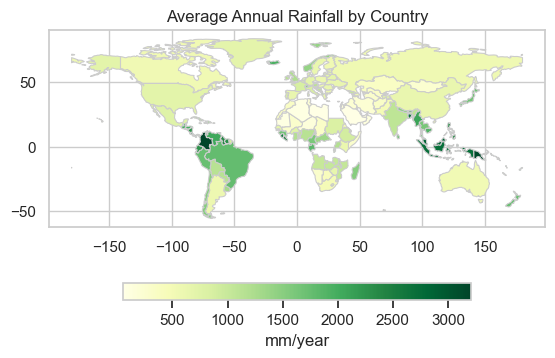

In [207]:
ax = geo_final.plot(column='avg_rainfall_mm_year', cmap='YlGn', linewidth=0.8, edgecolor='0.8')
plt.title("Average Annual Rainfall by Country")
# set colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=geo_final['avg_rainfall_mm_year'].min(), vmax=geo_final['avg_rainfall_mm_year'].max()))
cbar = plt.colorbar(sm, ax=ax, label='mm/year', orientation='horizontal',shrink=0.7)
plt.show()

In [61]:
# Average rain fall for each area over all years
area_byrain = df.groupby('Area')['avg_rainfall_mm_year'].mean().sort_values(ascending=False).reset_index()
top_20areas_byrain= area_byrain.head(20)
least_20areas_byrain= area_byrain.tail(20)

In [62]:
fig = px.bar(top_20areas_byrain, x='avg_rainfall_mm_year', y='Area', color='avg_rainfall_mm_year', color_continuous_scale=agro)
fig.update_layout(height=500, width=1500, title_text="Top 20 countries by average rain (mm)", title_x=0.5,xaxis_title='average rain (mm)',yaxis_title = '',
                  coloraxis_colorbar_title='average rain (mm)')  

In [63]:
fig = px.bar(least_20areas_byrain, x='avg_rainfall_mm_year', y='Area', color='avg_rainfall_mm_year', color_continuous_scale=agro)
fig.update_layout(height=500, width=1500, title_text="Least 20 countries by average rain (mm)", title_x=0.5,xaxis_title='average rain (mm)',yaxis_title = '',
                  coloraxis_colorbar_title='average rain (mm)')  

# pesticides

In [209]:
pest.shape

(77663, 5)

In [214]:
pest['pesticides_type'].value_counts()

pesticides_type
Insecticides                                            7703
Fungicides and Bactericides                             7414
Herbicides                                              7328
Plant Growth Regulators                                 4886
Rodenticides                                            4704
Other Pesticides nes                                    4098
Mineral Oils                                            3518
Fungicides : Seed treatments                            2909
Insecticides : Seed Treatments                          2422
Insecticides : Organo-phosphates                        1366
Insecticides : Pyrethroids                              1352
Insecticides : Other                                    1250
Herbicides : Other                                      1245
Fung & Bact : Other                                     1209
Fung & Bact : Dithiocarbamates                          1201
Disinfectants                                           1169
Insectic

In [215]:
pest_filtered.shape

(7738, 5)

<Axes: xlabel='Year'>

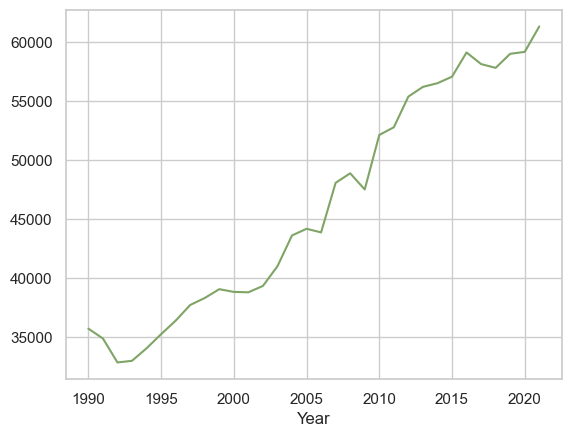

In [218]:
pest_filtered.groupby('Year')['agricultural_use_tonnes'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'agricultural_use_tonnes' for each year.

In [220]:
# group df by countries and years and do the yield mean
area_byyield = df.groupby(['Area','Year'])['yield_hg/ha'].mean().reset_index()

In [221]:
# group pest by countries and years and do the tonnes mean
pest_byyear = pest.groupby(['Area','Year'])['agricultural_use_tonnes'].mean().reset_index()

In [222]:
# merge both df
pest1 = pest_byyear.merge(area_byyield, on=['Area','Year'], how='inner')

In [234]:
pest1

,Area,Year,agricultural_use_tonnes,yield_hg/ha
0,Albania,1990,30.250000,83739.000000
1,Albania,1991,30.250000,81516.906250
2,Albania,1992,30.250000,87010.093750
3,Albania,1993,10.083333,92552.903226
4,Albania,1994,16.750000,98021.129032
...,...,...,...,...
4591,Zimbabwe,2017,312.152857,65100.044444
4592,Zimbabwe,2018,312.152857,66668.155556
4593,Zimbabwe,2019,312.152857,65884.333333
4594,Zimbabwe,2020,312.152857,66512.355556


In [238]:
# group pest1 by Areas and do the tonnes and yield mean
pest2 = pest1.groupby('Area')[['agricultural_use_tonnes','yield_hg/ha']].mean()

In [239]:
pest2

,agricultural_use_tonnes,yield_hg/ha
Area,,
Albania,53.122216,133450.636288
Algeria,905.710125,98358.589162
Angola,12.380389,64849.208045
Antigua and Barbuda,89.998672,60027.690868
Argentina,19252.485973,138869.651677
...,...,...
Ukraine,7691.379662,78073.195881
Uruguay,811.184965,117069.186149
Vanuatu,14.683516,63231.834821


In [263]:
df_corr = pest1.copy()

In [264]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     4596 non-null   object 
 1   Year                     4596 non-null   int64  
 2   agricultural_use_tonnes  4596 non-null   float64
 3   yield_hg/ha              4596 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 143.8+ KB


In [265]:
df_corr['Year'] = df_corr['Year'].astype(object)

In [266]:
# encode the object type variables to analize the correlation

from sklearn.preprocessing import LabelEncoder

# create an instance of the encoder
encoder = LabelEncoder() 
# Fit and transform the LabelEncoder on the column
for columns in df_corr.columns:
    if df_corr[columns].dtype == 'object':
        df_corr[columns] = encoder.fit_transform(df_corr[columns])


<Axes: >

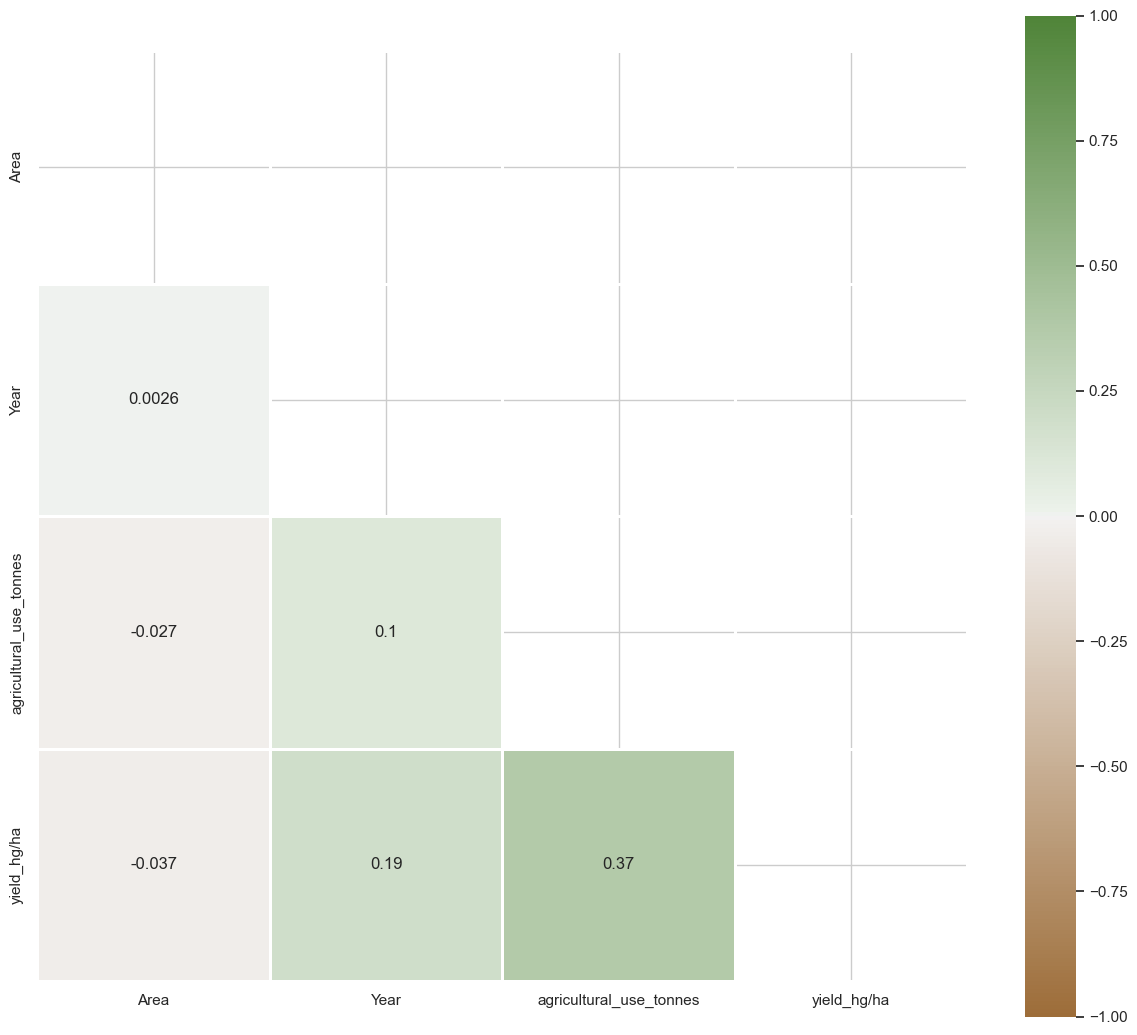

In [269]:
# Spearman's method 
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool)) 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(45, 120, s=75, l=50, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask[0:9,0:9], cmap=cmap, vmax=1, center=0, vmin=-1,  
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot = True)   

There is a moderate positive correlation between the use of pesticides and crop yields.

In [272]:
pest1

,Area,Year,agricultural_use_tonnes,yield_hg/ha
0,Albania,1990,30.250000,83739.000000
1,Albania,1991,30.250000,81516.906250
2,Albania,1992,30.250000,87010.093750
3,Albania,1993,10.083333,92552.903226
4,Albania,1994,16.750000,98021.129032
...,...,...,...,...
4591,Zimbabwe,2017,312.152857,65100.044444
4592,Zimbabwe,2018,312.152857,66668.155556
4593,Zimbabwe,2019,312.152857,65884.333333
4594,Zimbabwe,2020,312.152857,66512.355556


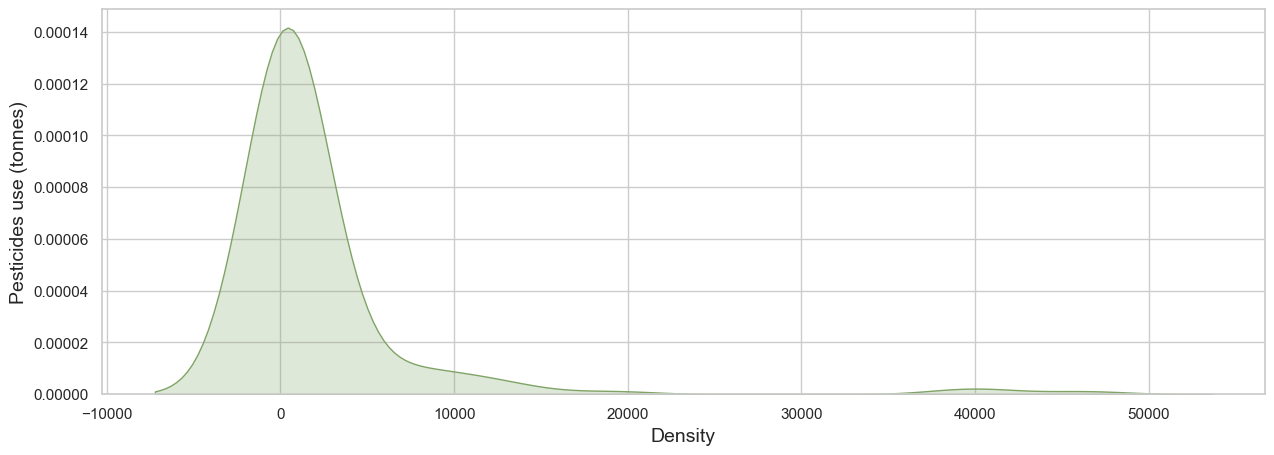

In [274]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=pest2, x='agricultural_use_tonnes', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Pesticides use (tonnes)', fontsize=14)
plt.show()

The majority of pesticides quantity is around 0.

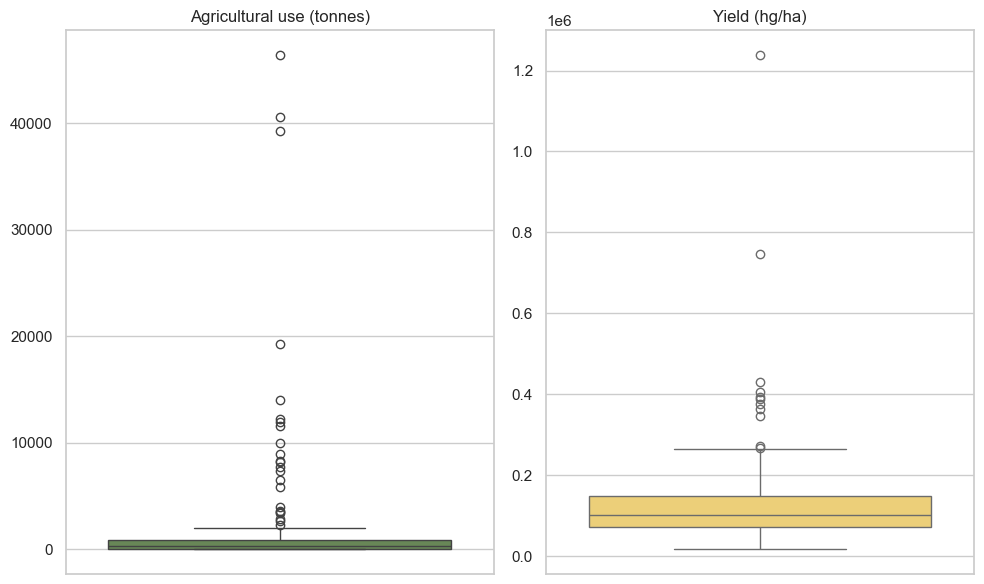

In [248]:
# Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Boxplot 1
sns.boxplot(y=pest2['agricultural_use_tonnes'], data=pest2, ax=axes[0], color = agro[3]) 
axes[0].set_title('Agricultural use (tonnes)')
axes[0].set_ylabel('')  

# Boxplot 2
sns.boxplot(y=pest2['yield_hg/ha'], data=pest2, ax=axes[1], color = agro[7]) 
axes[1].set_title('Yield (hg/ha)')
axes[1].set_ylabel('')  

plt.tight_layout()
plt.show()

In [247]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(pest2, pest2['agricultural_use_tonnes'])
repair_outliers(pest2, pest2['yield_hg/ha'])

,agricultural_use_tonnes,yield_hg/ha
Area,,
Albania,53.122216,133450.636288
Algeria,905.710125,98358.589162
Angola,12.380389,64849.208045
Antigua and Barbuda,89.998672,60027.690868
Argentina,19252.485973,138869.651677
...,...,...
Ukraine,7691.379662,78073.195881
Uruguay,811.184965,117069.186149
Vanuatu,14.683516,63231.834821


C:\Users\kina5\AppData\Local\Temp\ipykernel_24096\2456836354.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



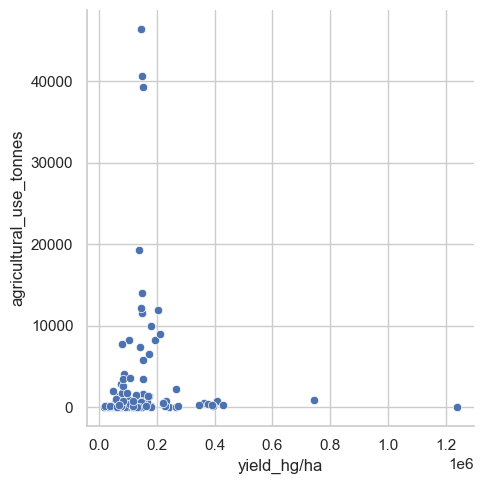

In [251]:
# Graficamos la relación entre 2 variables continuas -> Actúa de objetivo la variable body_mass_g

sns.relplot(data = pest2, x = 'yield_hg/ha', y = 'agricultural_use_tonnes',palette=agro) 

In [104]:
pestgroup_byyear = pest.groupby(['pesticides_group','Area','Year'])['agricultural_use_tonnes'].mean().reset_index()

In [106]:
pestgroup_byyear.shape

(49031, 4)

In [111]:
pest_final = pestgroup_byyear.merge(area_byyield, on=['Area','Year'], how='inner')

In [112]:
pest_final.shape

(27039, 5)

In [113]:
pest_final.head()

,pesticides_group,Area,Year,agricultural_use_tonnes,yield_hg/ha
0,Disinfectants,Benin,2010,0.02,68045.44
1,Disinfectants,Benin,2011,0.03,82110.12
2,Disinfectants,Benin,2012,0.03,74081.56
3,Disinfectants,Benin,2013,0.03,74352.40
4,Disinfectants,Benin,2014,0.03,75457.12


<Axes: xlabel='agricultural_use_tonnes', ylabel='pesticides_group'>

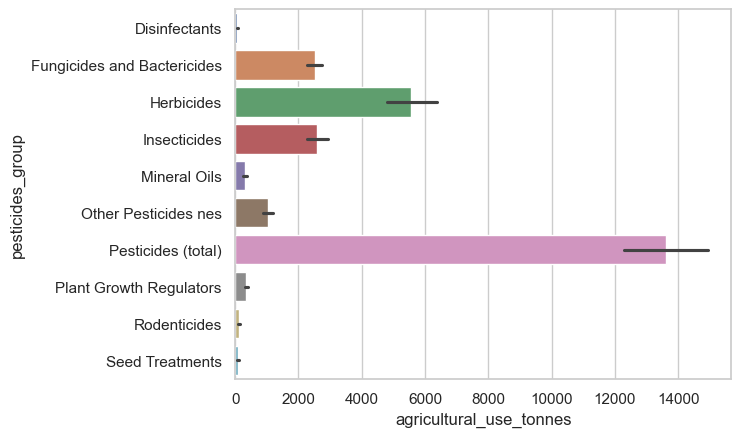

In [125]:
sns.barplot(data=pest_final, y='pesticides_group', x='agricultural_use_tonnes', hue='pesticides_group')

<Axes: xlabel='agricultural_use_tonnes', ylabel='yield_hg/ha'>

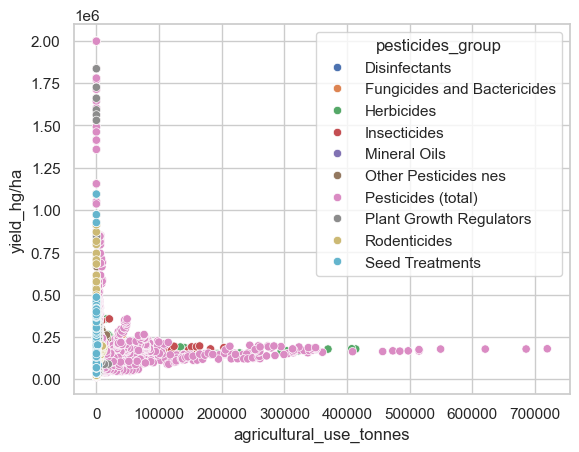

In [123]:
sns.scatterplot(data=pest_final, x='agricultural_use_tonnes', y='yield_hg/ha', hue='pesticides_group')

<Axes: xlabel='Year'>

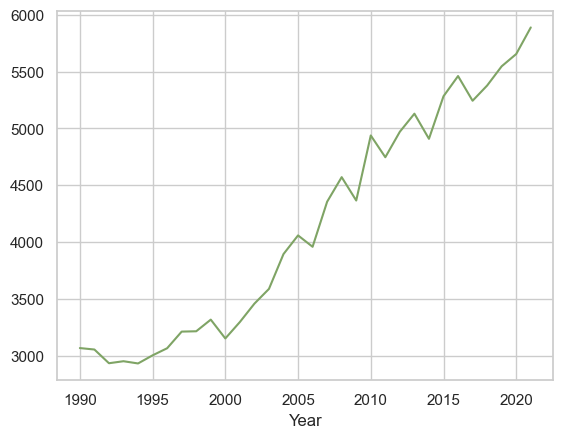

In [114]:
pest_final.groupby('Year')['agricultural_use_tonnes'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'agricultural_use_tonnes' for each year.

- top pesticides using countries